In [1]:
import pandas as pd

train = pd.read_csv("train.csv")

final_test = pd.read_csv("test.csv")

In [2]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


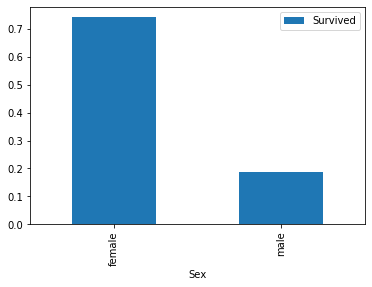

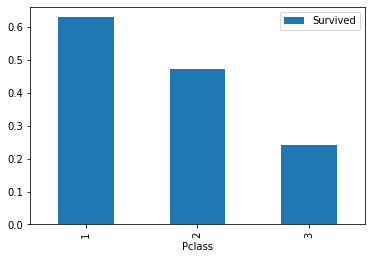

In [3]:
# Check the distributions of selected categorical columns
import matplotlib.pyplot as plt
%matplotlib inline

sex_pivot = train.pivot_table(index = "Sex",values = "Survived")
sex_pivot.plot.bar()
plt.show()

class_pivot = train.pivot_table(index = "Pclass",values = "Survived")
class_pivot.plot.bar()
plt.show()

In [4]:
# Missing values in Embarked
print(train["Embarked"].describe())

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object


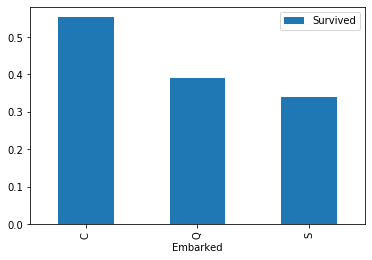

In [5]:
train["Embarked"] = train["Embarked"].fillna("S")
final_test["Embarked"] = final_test["Embarked"].fillna("S")

class_pivot = train.pivot_table(index = "Embarked",values = "Survived")
class_pivot.plot.bar()
plt.show()

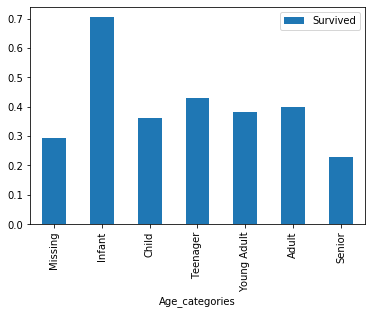

In [6]:
# Transform the age into a categorial feature
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

train = process_age(train)
final_test = process_age(final_test)

# Visualize the distribution of the age
pivot = train.pivot_table(index = "Age_categories",values = "Survived")
pivot.plot.bar()
plt.show()

In [7]:
# Create dummy variables for the categorical columns above
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df,dummies], axis=1)
    return df

cat_cols = ["Age_categories", "Pclass", "Sex", "Embarked"]

for col in cat_cols:
    train = create_dummies(train, col)
    final_test = create_dummies(final_test, col)

In [8]:
# Normalize the numerical columns
from sklearn.preprocessing import minmax_scale

num_cols = ["SibSp", "Parch", "Fare"]

for col in num_cols:
    train[col + "_normalized"] = minmax_scale(train[col])
    final_test[col + "_normalized"] = minmax_scale(final_test[col])

In [9]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_normalized', 'Parch_normalized', 'Fare_normalized'],
      dtype='object')


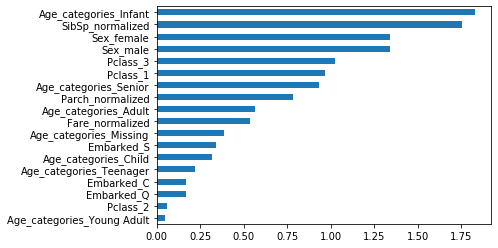

In [10]:
# Calculate the feature importance using logistic regression
from sklearn.linear_model import LogisticRegression
features_1 = ["Age_categories_Missing", "Age_categories_Infant", "Age_categories_Child", "Age_categories_Teenager", "Age_categories_Young Adult",
              "Age_categories_Adult", "Age_categories_Senior", "Pclass_1", "Pclass_2", "Pclass_3", "Sex_female", "Sex_male", "Embarked_C",
              "Embarked_Q", "Embarked_S", "SibSp_normalized", "Parch_normalized", "Fare_normalized"]

lr = LogisticRegression(solver="lbfgs")
lr.fit(train[features_1], train["Survived"])

impt = lr.coef_
features_impt_1 = pd.Series(impt[0], index = train[features_1].columns)
features_impt_1.abs().sort_values().plot.barh()

In [11]:
from sklearn.model_selection import cross_val_score

features_sel_1 = ["Age_categories_Infant", "SibSp_normalized", "Sex_female", "Sex_male", "Pclass_1", "Pclass_3",
                  "Age_categories_Senior", "Parch_normalized", "Fare_normalized", "Age_categories_Adult"]

lr2 = LogisticRegression(solver="lbfgs")
scores = cross_val_score(lr2, train[features_sel_1], train["Survived"], cv = 10)

accuracy = scores.mean()
print(accuracy)

0.811418681193962


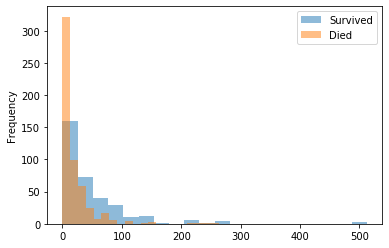

In [12]:
# Change the fare column into a categorical feature
train[train["Survived"] == 1]["Fare"].plot.hist(alpha = 0.5, label = "Survived", bins = 20)
train[train["Survived"] == 0]["Fare"].plot.hist(alpha = 0.5, label = "Died", bins = 20)
plt.legend()

In [13]:
def process_fare(df):
    cut_points = [0, 12, 50, 100, 1000]
    label_names = ["0-12", "12-50", "50-100", "100+"]
    df["Fare_categories"] = pd.cut(df["Fare"], cut_points, labels=label_names)
    return df

train = process_fare(train)
final_test = process_fare(final_test)

train = create_dummies(train, "Fare_categories")
final_test = create_dummies(final_test, "Fare_categories")

In [14]:
# Check the Name column to find out the titles of passengers and extract the first letter from the Cabin_type column
titles_map = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles_train = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles_train.map(titles_map)

extracted_titles_test = final_test["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
final_test["Title"] = extracted_titles_test.map(titles_map)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

final_test["Cabin_type"] = final_test["Cabin"].str[0]
final_test["Cabin_type"] = final_test["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    final_test = create_dummies(final_test,column)
    
print(final_test.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_normalized', 'Parch_normalized', 'Fare_normalized',
       'Fare_categories', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title', 'Cabin_type',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_Unknown'],
      dtype='object')


In [15]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_normalized', 'Parch_normalized', 'Fare_normalized',
       'Fare_categories', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title', 'Cabin_type',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown'],
      dtype='object')


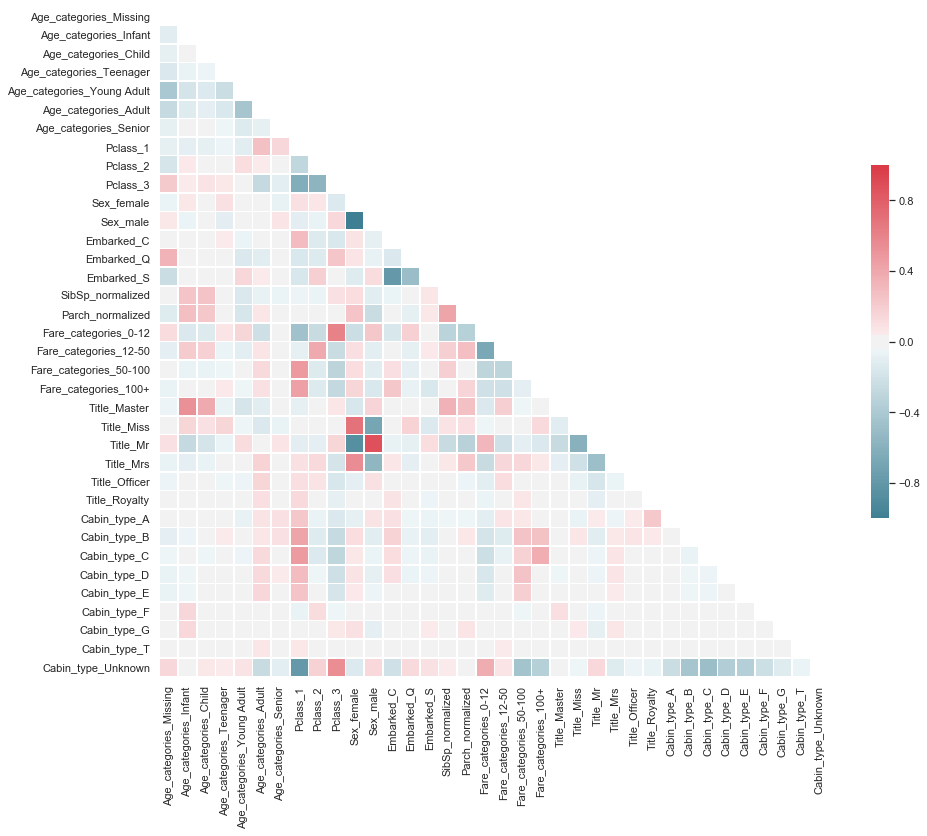

In [16]:
# Check the correlations between the available features
features_2 = ["Age_categories_Missing", "Age_categories_Infant", "Age_categories_Child", "Age_categories_Teenager", "Age_categories_Young Adult",
              "Age_categories_Adult", "Age_categories_Senior", "Pclass_1", "Pclass_2", "Pclass_3", "Sex_female", "Sex_male", "Embarked_C",
              "Embarked_Q", "Embarked_S", "SibSp_normalized", "Parch_normalized", "Fare_categories_0-12", "Fare_categories_12-50",
              "Fare_categories_50-100", "Fare_categories_100+", "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Officer",
              "Title_Royalty", "Cabin_type_A", "Cabin_type_B", "Cabin_type_C", "Cabin_type_D", "Cabin_type_E", "Cabin_type_F", "Cabin_type_G",
              "Cabin_type_T", "Cabin_type_Unknown"]

    
import numpy as np
import seaborn as sns

corr = train[features_2].corr()
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [17]:
# Remove Sex_male and Sex_female
# Remove one of each of the dummy variables to redue the collinearity in each
features_3 = ["Age_categories_Missing", "Age_categories_Infant", "Age_categories_Child", "Age_categories_Young Adult",
              "Age_categories_Adult", "Age_categories_Senior", "Pclass_1", "Pclass_3", "Sex_female", "Sex_male", "Embarked_C", "Embarked_Q",
              "Embarked_S", "SibSp_normalized", "Parch_normalized", "Fare_categories_0-12", "Fare_categories_50-100", "Fare_categories_100+",
              "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Officer", "Title_Royalty","Cabin_type_B", "Cabin_type_C", "Cabin_type_D",
              "Cabin_type_E", "Cabin_type_F", "Cabin_type_G", "Cabin_type_T", "Cabin_type_Unknown"]

In [18]:
# Use recursive feature elimination to select optimal features
from sklearn.feature_selection import RFECV

lr3 = LogisticRegression(solver="lbfgs")
selector = RFECV(lr3, cv=10)
selector.fit(train[features_3], train["Survived"])

optimal_columns = train[features_3].columns[selector.support_]
print(optimal_columns)

Index(['SibSp_normalized', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


In [19]:
lr4 = LogisticRegression(solver="lbfgs")

scores_2 = cross_val_score(lr4, train[optimal_columns], train["Survived"], cv=10)
accuracy_2 = scores_2.mean()
print(accuracy_2)

0.8226549199863807


In [20]:
lr5 = LogisticRegression(solver="lbfgs")

lr5.fit(train[optimal_columns], train["Survived"])
test_predictions = lr5.predict(final_test[optimal_columns])

final_test_IDs = final_test["PassengerId"]
submission_df = {"PassengerId": final_test_IDs,
                 "Survived": test_predictions}

submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)